In [1]:
from absl import logging
import numpy as np
import tensorflow.compat.v1 as tf

from open_spiel.python import rl_environment
from open_spiel.python.algorithms import dqn
from open_spiel.python.algorithms import random_agent

2023-10-09 10:36:33.340302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Training parameters
#Directory to save/load the agent models.
checkpoint_dir = "/Users/titus/open_spiel/training/MLAgents/Checkers"

#Episode frequency at which the DQN agent models are saved
save_every = int(1e4)

#Number of training episodes.
num_train_episodes = int(1e6)

#Episode frequency at which the DQN agents are evaluated.
eval_every = 1000


# DQN model hyper-parameters

#Number of hidden units in the Q-Network MLP
hidden_layers_sizes = [64, 64]

#Size of the replay buffer
replay_buffer_capacity = int(1e5)

#Number of transitions to sample at each learning step.                     )
batch_size = 32

In [3]:
def eval_against_random_bots(env, trained_agents, random_agents, num_episodes):
  """Evaluates `trained_agents` against `random_agents` for `num_episodes`."""
  num_players = len(trained_agents)
  sum_episode_rewards = np.zeros(num_players)
  for player_pos in range(num_players):
    cur_agents = random_agents[:]
    cur_agents[player_pos] = trained_agents[player_pos]
    for _ in range(num_episodes):
      time_step = env.reset()
      episode_rewards = 0
      while not time_step.last():
        player_id = time_step.observations["current_player"]
        if env.is_turn_based:
          agent_output = cur_agents[player_id].step(
              time_step, is_evaluation=True)
          action_list = [agent_output.action]
        else:
          agents_output = [
              agent.step(time_step, is_evaluation=True) for agent in cur_agents
          ]
          action_list = [agent_output.action for agent_output in agents_output]
        time_step = env.step(action_list)
        episode_rewards += time_step.rewards[player_pos]
      sum_episode_rewards[player_pos] += episode_rewards
  return sum_episode_rewards / num_episodes

In [7]:
game = "checkers"
num_players = 2
env = rl_environment.Environment(game)
info_state_size = env.observation_spec()["info_state"][0]
num_actions = env.action_spec()["num_actions"]

# random agents for evaluation
random_agents = [
    random_agent.RandomAgent(player_id=idx, num_actions=num_actions)
    for idx in range(num_players)
]

with tf.Session() as sess:
  hidden_layers_sizes = [int(l) for l in hidden_layers_sizes]
  # pylint: disable=g-complex-comprehension
  agents = [
      dqn.DQN(
          session=sess,
          player_id=idx,
          state_representation_size=info_state_size,
          num_actions=num_actions,
          hidden_layers_sizes=hidden_layers_sizes,
          replay_buffer_capacity=replay_buffer_capacity,
          batch_size=batch_size) for idx in range(num_players)
  ]
  sess.run(tf.global_variables_initializer())

  result = []
  print("Start Training...")
  for ep in range(num_train_episodes):
    if (ep + 1) % 100 == 0:
        print(ep+1)
    if (ep + 1) % eval_every == 0:
      r_mean = eval_against_random_bots(env, agents, random_agents, 1000)
      logging.info("[%s] Mean episode rewards %s", ep + 1, r_mean)
      print("Mean episode rewards", ep + 1, r_mean)
      result.append(r_mean)
    if (ep + 1) % save_every == 0:
      for agent in agents:
        agent.save(checkpoint_dir)

    time_step = env.reset()
    while not time_step.last():
      player_id = time_step.observations["current_player"]
      if env.is_turn_based:
        agent_output = agents[player_id].step(time_step)
        action_list = [agent_output.action]
      else:
        agents_output = [agent.step(time_step) for agent in agents]
        action_list = [agent_output.action for agent_output in agents_output]
      time_step = env.step(action_list)

    # Episode is over, step all agents with final info state.
    for agent in agents:
      agent.step(time_step)

2023-10-09 10:38:14.299670: W tensorflow/c/c_api.cc:291] Operation '{name:'mlp_11/bias_2/Assign' id:1989 op device:{requested: '', assigned: ''} def:{{{node mlp_11/bias_2/Assign}} = Assign[T=DT_FLOAT, _class=["loc:@mlp_11/bias_2"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](mlp_11/bias_2, mlp_11/zeros_2)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Start Training...
100
200
300
400
500
600
700
800
900
1000
Mean episode rewards 1000 [0.178 0.274]
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
Mean episode rewards 2000 [0.259 0.368]
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
Mean episode rewards 3000 [0.411 0.393]
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
Mean episode rewards 4000 [0.369 0.415]
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
Mean episode rewards 5000 [0.347 0.459]
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
Mean episode rewards 6000 [0.349 0.372]
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
Mean episode rewards 7000 [0.214 0.321]
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
Mean episode rewards 8000 [0.361 0.296]
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
Mean episode rewards 9000 [0.385 0.219]
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
Mean episode rewards 10000 [0.24  0.344]
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
Mean episode rewards 11000 [0

82400
82500
82600
82700
82800
82900
83000
Mean episode rewards 83000 [0.893 0.92 ]
83100
83200
83300
83400
83500
83600
83700
83800
83900
84000
Mean episode rewards 84000 [0.909 0.918]
84100
84200
84300
84400
84500
84600
84700
84800
84900
85000
Mean episode rewards 85000 [0.873 0.891]
85100
85200
85300
85400
85500
85600
85700
85800
85900
86000
Mean episode rewards 86000 [0.873 0.901]
86100
86200
86300
86400
86500
86600
86700
86800
86900
87000
Mean episode rewards 87000 [0.859 0.914]
87100
87200
87300
87400
87500
87600
87700
87800
87900
88000
Mean episode rewards 88000 [0.818 0.91 ]
88100
88200
88300
88400
88500
88600
88700
88800
88900
89000
Mean episode rewards 89000 [0.88  0.919]
89100
89200
89300
89400
89500
89600
89700
89800
89900
90000
Mean episode rewards 90000 [0.892 0.929]
90100
90200
90300
90400
90500
90600
90700
90800
90900
91000
Mean episode rewards 91000 [0.859 0.91 ]
91100
91200
91300
91400
91500
91600
91700
91800
91900
92000
Mean episode rewards 92000 [0.86  0.923]
92100
92

Exception ignored in: <function BaseSession.__del__ at 0x7fcb2d6a3160>
Traceback (most recent call last):
  File "/Users/titus/anaconda3/envs/rl/lib/python3.8/site-packages/tensorflow/python/client/session.py", line 770, in __del__
    try:
KeyboardInterrupt: 

KeyboardInterrupt



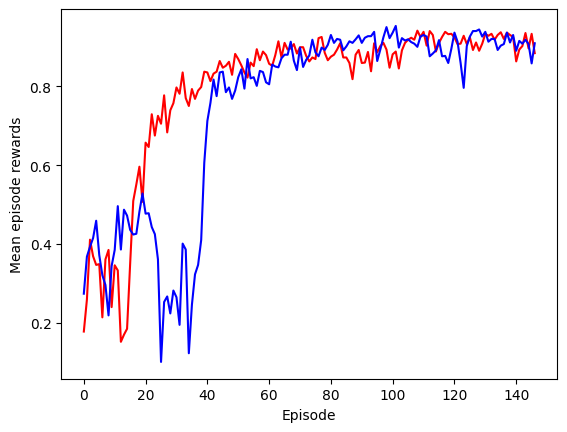

In [9]:
import matplotlib.pyplot as plt

ep = [x for x in range(len(result))]
pt_r_mean0 = [y[0] for y in result]
pt_r_mean1 = [y[1] for y in result]

plt.plot(ep,pt_r_mean0, c='red')
plt.plot(ep,pt_r_mean1, c='blue')
plt.xlabel('Episode')
plt.ylabel('Mean Episode Rewards')
plt.savefig('/Users/titus/Desktop/checkers_dqn_training.pdf')
plt.show()